# Dataset

* Dataser has 10,000 rows and 14 columns
* Variables:
    - **RowNumber**: id do registro/linha.
    - **CustomerId**: identificador único do cliente.
    - **Surname**: sobrenome do cliente.
    - **CreditScore**: pontuação de crédito do cliente.
    - **Geography**: país de origem do cliente.
    - **Gender**: sexo do cliente.
    - **Age**: idade do cliente.
    - **Tenure**: número de anos em que o cliente está com o banco.
    - **Balance**: saldo bancário.
    - **NumOfProducts**: número de produtos que o cliente utiliza.
    - **HasCrCard**: indica se o cliente tem (1) ou não tem (0) cartão de crédito.
    - **IsActiveMember**: indica se o cliente é (1) ou não é (0) ativo no banco.
    - **EstimatedSalary**: salário estimado em dólares.
    - **Exited**: indica se o cliente encerrou (1) a conta no banco ou se o cliente foi retido (0).
* Business Goal is develop a ML to predict who will exit.
* You can find the dataset at [Kaggle](https://www.kaggle.com/shrutimechlearn/churn-modelling)

## Preparing the notebook

In [1]:
! pip install imblearn

In [2]:
# Imports

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from scipy import stats

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix

In [3]:
# Accesing the document
df = pd.read_csv('Churn_Modelling.csv', sep=',')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Exploratory analysis
Variables:
* Age has positive skewness
* Age outliers represent elder people which 79.6% are actual clients
* The "stimative of salary", "tenure" and "credit score" aren't good features, because it doesn't differ a lot between target's groups
* Categorical feature are imbalanced

Insigths:
* 3623 clients have a balance between 0 and 25k
* Older than 45 years are active members and actual clients
* This sample shows all clients with 4 products exited (total of 60) and clients with 3 products 82% exited (total of 220)
* At this sample we have 79% of actual clients and 21% clients exited from business
* The sample show a bigger frequency of exited german clients with a balance between 90k and 160k





In [4]:
# Dimensões do DF
df.shape

(10000, 14)

In [5]:
# Looking for null and type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Checking for duplicates
df.duplicated().sum()

0

In [7]:
# Dropping unimportant columns 
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)


In [8]:
# Transforming the columns name
df.columns = df.columns.str.lower()

In [9]:
# Transforming string values
df['geography'] = df['geography'].apply(lambda x: x.lower())

In [10]:
# Defining variables groups
continuous_var = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']
categorical_var = ['geography', 'gender', 'hascrcard', 'numofproducts', 'isactivemember']

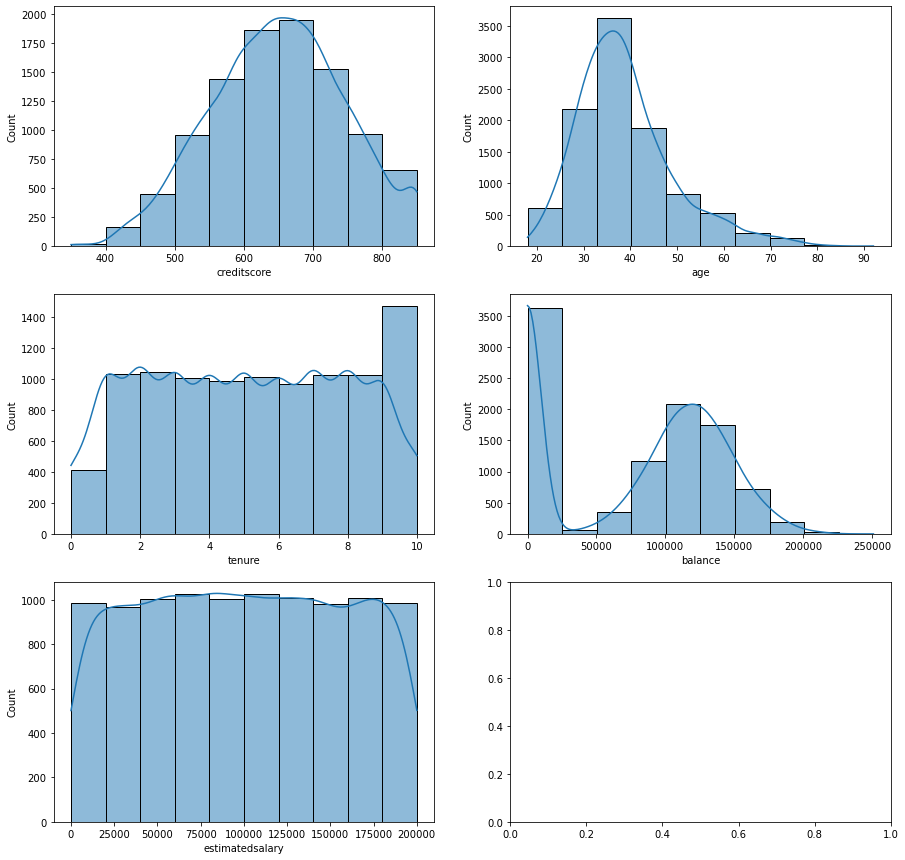

In [11]:
# General distribution | histogram for which continuous variable
n_rows=3
n_cols=2

## Creating subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(15, 15)

## Creating histograms
for i, column in enumerate(continuous_var):
  sns.histplot(df[column], ax=axes[i//n_cols,i%n_cols], bins=10, kde=True)

plt.show()

In [12]:
# analysing the 0 to 25k balance
df[df['balance'] <= 25000].describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000
mean,649.487993,38.440795,5.072040,26.202327,1.783881,0.716257,0.517803,99042.015636,0.139111
std,96.115166,10.485391,2.861722,702.260478,0.496753,0.450876,0.499752,57735.343527,0.346110
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,583.000000,31.000000,3.000000,0.000000,1.000000,0.000000,0.000000,49573.700000,0.000000
50%,651.000000,37.000000,5.000000,0.000000,2.000000,1.000000,1.000000,98621.040000,0.000000
75%,716.500000,43.000000,7.000000,0.000000,2.000000,1.000000,1.000000,148522.515000,0.000000
max,850.000000,88.000000,10.000000,24043.450000,4.000000,1.000000,1.000000,199992.480000,1.000000


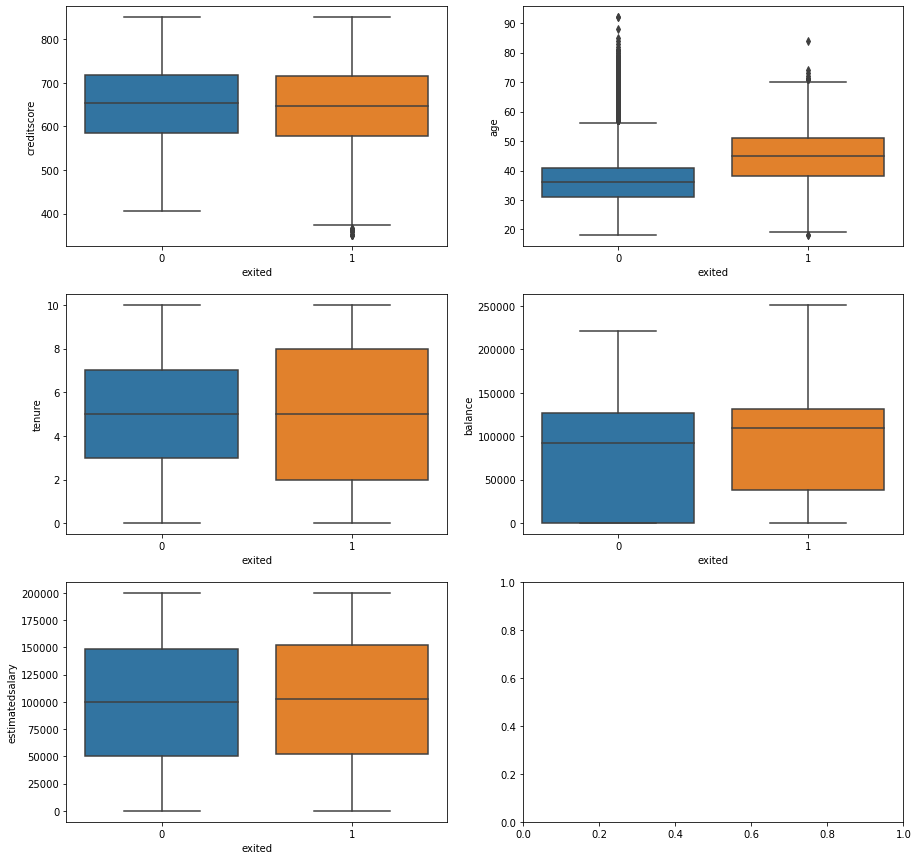

In [13]:
# General distribution | boxplot for which continuous variable & Target
n_rows=3
n_cols=2

## Creating subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(15, 15)

## Creating boxplot
for i, column in enumerate(continuous_var):
  sns.boxplot(x=df['exited'], y=df[column], ax=axes[i//n_cols,i%n_cols])

plt.show()

In [14]:
# analysing outliers 
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
_ = df[((df['age'] < (Q1 - 1.5 * IQR)) | (df['age'] > (Q3 + 1.5 * IQR)))]

In [15]:
# Analysing the outlier's data
_.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000
mean,657.005571,69.270195,4.944290,74477.573649,1.509749,0.713092,0.835655,97883.247354,0.203343
std,95.515713,5.237059,2.982671,62335.296038,0.583085,0.452950,0.371106,57499.034723,0.403047
min,408.000000,63.000000,0.000000,0.000000,1.000000,0.000000,0.000000,502.700000,0.000000
25%,596.000000,65.000000,2.000000,0.000000,1.000000,0.000000,1.000000,49530.100000,0.000000
50%,657.000000,68.000000,5.000000,95039.120000,1.000000,1.000000,1.000000,97893.400000,0.000000
75%,720.000000,72.000000,8.000000,126389.985000,2.000000,1.000000,1.000000,145873.755000,0.000000
max,850.000000,92.000000,10.000000,187013.130000,4.000000,1.000000,1.000000,199493.380000,1.000000


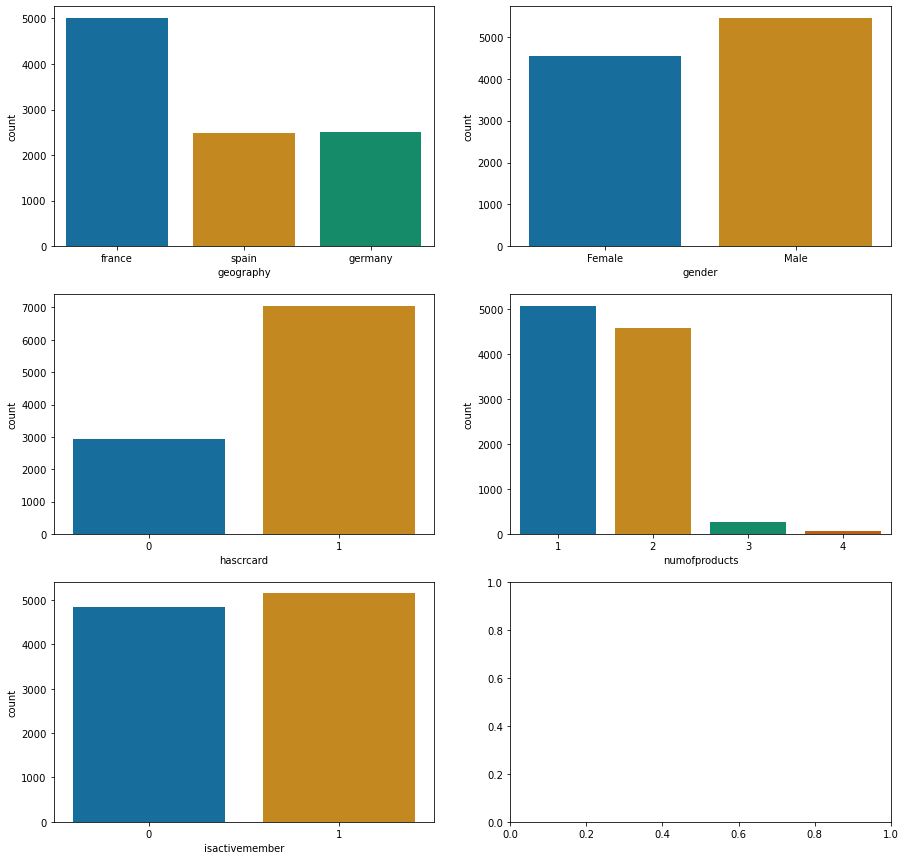

In [16]:
# General distribution | boxplot for which Categorical
n_rows=3
n_cols=2

## Creating subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(15, 15)

## Creating boxplot
for i, column in enumerate(categorical_var):
  sns.countplot(x=df[column], ax=axes[i//n_cols,i%n_cols], palette='colorblind')

plt.show()

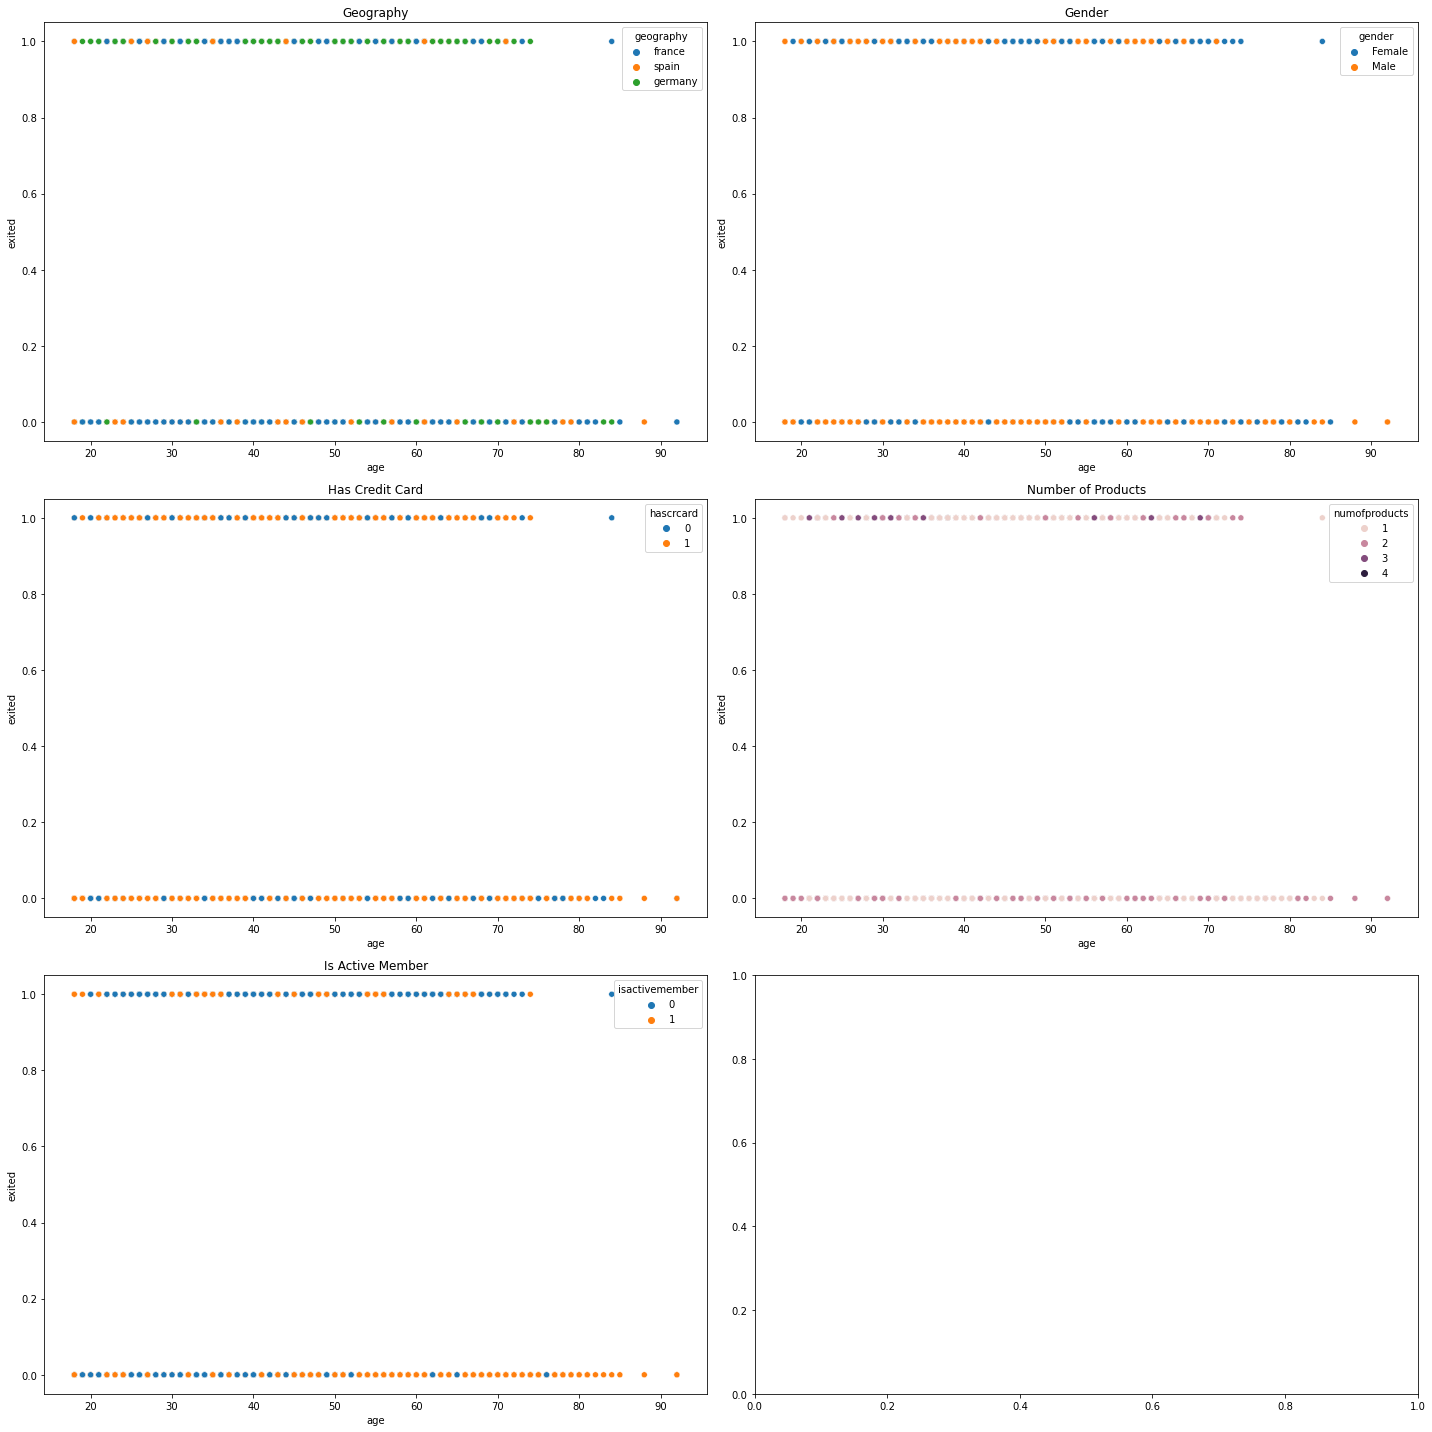

In [17]:
# Distribution of continuous variables + age + exited
n_rows=3
n_cols=2
target = ['exit']

## Subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(20, 20)

## target | gender
sns.scatterplot(x='age',y='exited',hue='geography',data=df, ax=axs[0, 0])
axs[0,0].set_title('Geography')

sns.scatterplot(x='age',y='exited',hue='gender',data=df, ax=axs[0, 1])
axs[0,1].set_title('Gender')

sns.scatterplot(x='age',y='exited',hue='hascrcard',data=df, ax=axs[1, 0])
axs[1,0].set_title('Has Credit Card')

sns.scatterplot(x='age',y='exited',hue='numofproducts',data=df, ax=axs[1, 1])
axs[1,1].set_title('Number of Products')

sns.scatterplot(x='age',y='exited',hue='isactivemember',data=df, ax=axs[2, 0])
axs[2,0].set_title('Is Active Member')

plt.tight_layout()
plt.show()

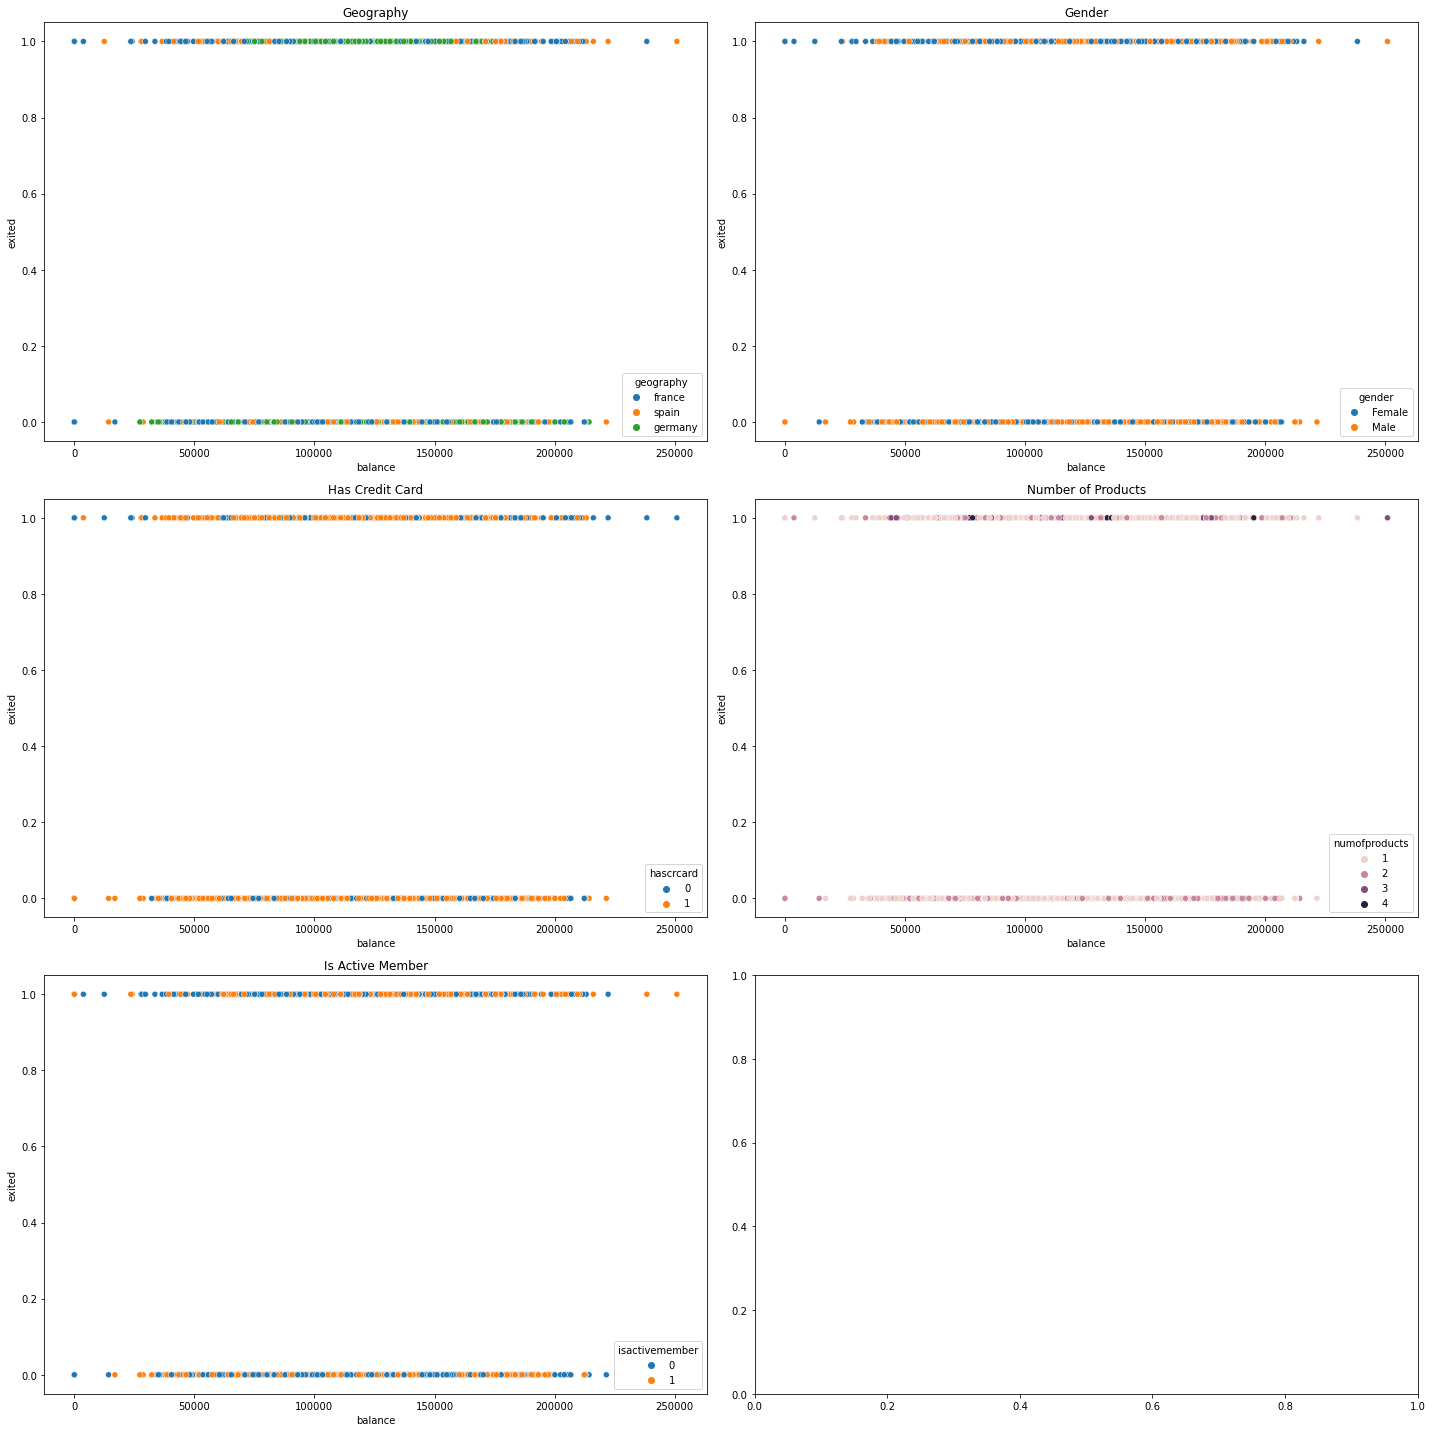

In [18]:
# Distribution of continuous variables + balance + exited
n_rows=3
n_cols=2
target = ['exit']

## Subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(20, 20)

## target | gender
sns.scatterplot(x='balance',y='exited',hue='geography',data=df, ax=axs[0, 0])
axs[0,0].set_title('Geography')

sns.scatterplot(x='balance',y='exited',hue='gender',data=df, ax=axs[0, 1])
axs[0,1].set_title('Gender')

sns.scatterplot(x='balance',y='exited',hue='hascrcard',data=df, ax=axs[1, 0])
axs[1,0].set_title('Has Credit Card')

sns.scatterplot(x='balance',y='exited',hue='numofproducts',data=df, ax=axs[1, 1])
axs[1,1].set_title('Number of Products')

sns.scatterplot(x='balance',y='exited',hue='isactivemember',data=df, ax=axs[2, 0])
axs[2,0].set_title('Is Active Member')

plt.tight_layout()
plt.show()

In [19]:
df.groupby(['numofproducts', 'exited']).count()

creditscore  geography  gender   age  tenure  balance  \
numofproducts exited                                                          
1             0              3675       3675    3675  3675    3675     3675   
              1              1409       1409    1409  1409    1409     1409   
2             0              4242       4242    4242  4242    4242     4242   
              1               348        348     348   348     348      348   
3             0                46         46      46    46      46       46   
              1               220        220     220   220     220      220   
4             1                60         60      60    60      60       60   

                      hascrcard  isactivemember  estimatedsalary  
numofproducts exited                                              
1             0            3675            3675             3675  
              1            1409            1409             1409  
2             0            4242            4242             4242  
              1             348             348              348  
3             0              46              46               46  
              1             220             220              220  
4             1              60              60               60

In [20]:
df.groupby(['isactivemember', 'exited']).count()

creditscore  geography  gender   age  tenure  balance  \
isactivemember exited                                                          
0              0              3547       3547    3547  3547    3547     3547   
               1              1302       1302    1302  1302    1302     1302   
1              0              4416       4416    4416  4416    4416     4416   
               1               735        735     735   735     735      735   

                       numofproducts  hascrcard  estimatedsalary  
isactivemember exited                                             
0              0                3547       3547             3547  
               1                1302       1302             1302  
1              0                4416       4416             4416  
               1                 735        735              735

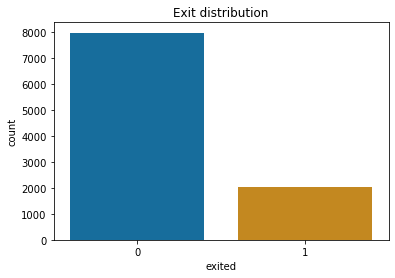

In [21]:
sns.countplot(x=df['exited'], palette='colorblind')
plt.title('Exit distribution')
plt.show()

### Feature engineering

In [22]:
# Encoding gender
onehot = OneHotEncoder()

_ = pd.DataFrame(onehot.fit_transform(df[['gender']]).toarray(),columns=onehot.get_feature_names(['gender']))
df = df.merge(_, how='right',  on=df.index)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
# Encoding geography
_ = pd.DataFrame(onehot.fit_transform(df[['geography']]).toarray(),columns=onehot.get_feature_names(['geography']))
df = df.merge(_, how='right',  on=df.index)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [64]:
# Deletando a coluna gender, key_0 and geography
df.drop(columns=['gender','key_0', 'geography'], inplace=True)

In [66]:
# Renaming the binary columns
df.rename(columns={'gender_Female':'female', 'gender_Male':'male', 'geography_france': 'france','geography_germany':'germany', 'geography_spain':'spain'}, inplace=True)

SyntaxError: invalid syntax (<ipython-input-66-0e91d39f1f2c>, line 2)

In [25]:
# Defining the features
continuous_feat = ['age', 'balance']
categorical_feat = ['geography', 'gender', 'hascrcard', 'numofproducts', 'isactivemember', 'female', 'male']

In [26]:
# Defining df
continuous_df = ['age', 'balance', 'exited']
categorical_df = ['geography', 'hascrcard', 'numofproducts', 'isactivemember', 'female', 'male', 'exited']

### 3.4 Construção do modelo

In [77]:
# Creating scenarios
features = ['all']
scalling = ['none']
rebalance = ['none', 'smote']
algorithm = ['dummie', 'logistic', 'knn', 'tree_clas']

In [58]:
# Creating the function to create scenarios

def create_scenarios(features, scalling, rebalance, algorithm):
  ''' It combines de list of strings from variables to create 
  differents scenarios to run de model.
  Input: variables separated by coma. Each variable contains a list of strings.
        if there are no situation in some variable, insert 'none'. 
  Output: a variable called 'scenarios' which contains a list of dictionary. '''

  # Creating scenarios/combinations
  global scenarios 
  scenarios = []
  for f in features:
      for s in scalling:
        for r in rebalance:
          for a in algorithm:
              scenario = {'features': f, 
                          'scalling': s,
                          'rebalance': r,
                          'algorithm': a,
                          }
              scenarios.append(scenario)
  print(f'There are {len(scenarios)} possible scenarios.')

In [78]:
create_scenarios(features, scalling, rebalance, algorithm)

There are 8 possible scenarios.


In [90]:
# Creating the function to run scenarios

def run_model(df, scenarios):
  '''
  Function to run the scenarios.
  Input: dataframe,
         variable 'scenarios'
  Output: return the scenario analysed and the metrics.
  '''

  # Running each scenario
  for scenario in scenarios:  
    print(scenario)
    if scenario['features'] == 'continuous':
      dft = df[continuous_df]
    elif scenario['features'] == 'categorical':
      dft = df[categorical_df]
    elif scenario['features'] == 'all':
      dft = df
    else:
      print('Passed the features')
    ## Split train & test0
    X = dft.drop(columns = 'exited')
    y = dft['exited']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Size confirmation
    #print(f'Dataframe    X_train    y_train    X_test    y_test')
    #print(f'{dft.shape} == {X_train.shape} + {y_train.shape} + {X_test.shape} + {y_test.shape}')
    ## scalling  
    if scenario['scalling'] == 'none':
        pass
    elif scenario['scalling'] == 'robust':
      robust = RobustScaler()
      X_train = robust.fit_transform(X_train)
      X_test = robust.transform(X_test)
    elif scenario['scalling'] == 'z-score':
      _ = [X_train, X_test]
      for df in _:
        for col in df[continuous_feat]:
          df[col] = stats.zscore(df[col])
    else:
      print('Passed the scalling')
    ## rebalance
    if scenario['rebalance'] == 'none':
      pass
    elif scenario['rebalance'] == 'smote':
      smote = SMOTE(k_neighbors=1)
      X_train, y_train = smote.fit_resample(X_train, y_train)
      X_test, y_test = smote.fit_resample(X_test, y_test)
    else:
      print('Passed the rebalance')
    ## algorithm
    if scenario['algorithm'] == 'dummie':
      model = DummyClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'logistic':
      model = LogisticRegression() 
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'knn':
      model = KNeighborsClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'tree_clas':
      model = DecisionTreeClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'random':
      model = RandomForestClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    else:
      print('Passed the algorithm')
    global results
    results = [{'Accuracy': accuracy_score(y_test, y_pred), 
                'Precision': precision_score(y_test, y_pred, average='weighted'),
                'Recall:': recall_score(y_test, y_pred, average='weighted'),
                'F1-score:': f1_score(y_test, y_pred, average='weighted')}]
    print(results)
    print('='*40)


In [94]:
run_model(df,scenarios)

{'features': 'all', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'dummie'}
[{'Accuracy': 0.7945, 'Precision': 0.63123025, 'Recall:': 0.7945, 'F1-score:': 0.7035165784341042}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'logistic'}
[{'Accuracy': 0.8045, 'Precision': 0.7440284090909092, 'Recall:': 0.8045, 'F1-score:': 0.7435173672436124}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'knn'}
[{'Accuracy': 0.767, 'Precision': 0.687363436274847, 'Recall:': 0.767, 'F1-score:': 0.7151672855879753}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'tree_clas'}
[{'Accuracy': 0.789, 'Precision': 0.7916216931216932, 'Recall:': 0.789, 'F1-score:': 0.7902687581699347}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'smote', 'algorithm': 'dummie'}
[{'Accuracy': 0.5, 'Precision': 0.25, 'Recall:': 0.5, 'F1-score:': 0.3333333333333333}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'smote', 'algorit

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'Accuracy': 0.680910792264504, 'Precision': 0.6814208955410275, 'Recall:': 0.680910792264504, 'F1-score:': 0.6806863377648458}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'smote', 'algorithm': 'knn'}
[{'Accuracy': 0.5108005082592122, 'Precision': 0.511514700844991, 'Recall:': 0.5108005082592122, 'F1-score:': 0.5030954548063598}]
{'features': 'all', 'scalling': 'none', 'rebalance': 'smote', 'algorithm': 'tree_clas'}
[{'Accuracy': 0.8118622448979592, 'Precision': 0.8136384832494784, 'Recall:': 0.8118622448979592, 'F1-score:': 0.8115954956595197}]


### Conclusions
The best result we have was:
        {'features': 'all', 'scalling': 'none', 'rebalance': 'smote', 'algorithm': 'tree_clas'}
        [{'Accuracy': 0.8118622448979592, 'Precision': 0.8136384832494784, 'Recall:': 0.8118622448979592, 
        'F1-score:': 0.8115954956595197}]

We can predict 81% of data correctly and getting a little more false positives than false negatives.
Once we will calculate the churn rate to define company plans, It was consider a better choice getting false postives (clients how have exited in predict, but haven't on real life).